# Simulations

In this notebook we detail how simulations to generate measured events that can be analysed with GammaBayes. 

There are essentially three steps to these simulations.

1. Setup: Create the relevant priors and likelihoods that describe your astrophysical sources and instrumental noise (there is a more detailed explanation on these in the relevant notebooks)

2. True Value Sampling: Sample the priors to obtain the "true values" that correspond to what a perfect instrument would see

3. Measured Value Sampling: With the true value samples, sample the likelihoods to add noise to the measurements to obtain events similar to what the CTA would see

## 1. Setup

### Axes

We will first create the our priors. For this we will need to set up the axes over which the true values can be made in `$log_10$ Energy`, `galactic longitude` and `galactic latitude`.

For now we will let there be 100 bins per decade in energy from 0.1 TeV to 100 TeV. The bounds in all cases mostly being defined by where the Instruments Response Functions (our likelihoods) are well-defined.

Our Galactic Latitude will have the bounds of -3.5 to 3.5 (our 356.5 to 3.5 if you prefer, but the math is easier with symmetry) with a resolution of 0.4. This is not what one would want to use in a full-blown simulation, but any increase in particularly the spatial axes can significantly increase computation time for later stages of analysis.

Our Galactic Longitude will then have bounds of -3.0 to 3.0 also with a resolution of 0.4. This is mostly to show you don't need a completely symmetry observation window here and can use whatever you wish.

These axes are named `log10_eaxis_true`, `longitude_axis_true` and `latitude_axis_true` respectively.

In [1]:
import numpy as np


# log10 true energy axis
true_energy_bins_per_decade      = 100
log10_e_true_lowerbound          = np.log10(0.1)
log10_e_true_upperbound          = np.log10(100)
log10_e_true_range               = log10_e_true_upperbound-log10_e_true_lowerbound

log10_eaxis_true            = np.linspace(log10_e_true_lowerbound,log10_e_true_upperbound,int(np.round(log10_e_true_range*true_energy_bins_per_decade))+1)

log10_mass = np.log10(1)


# spatial axes

true_value_spatial_resolution = 0.2

## longitude axis
longitude_true_axis_lowerbound   = -3.5
longitude_true_axis_upperbound   = 3.5
longitude_true_axis_range        = longitude_true_axis_upperbound-longitude_true_axis_lowerbound

longitude_axis_true           = np.linspace(longitude_true_axis_lowerbound, 
                                            longitude_true_axis_upperbound, 
                                            int(round(longitude_true_axis_range/true_value_spatial_resolution)+1)) 

## latitude axis
latitude_true_axis_lowerbound    = -3.
latitude_true_axis_upperbound    = 3.
latitude_true_axis_range         = latitude_true_axis_upperbound-latitude_true_axis_lowerbound

latitude_axis_true            = np.linspace(latitude_true_axis_lowerbound, 
                                            latitude_true_axis_upperbound, 
                                            int(round(latitude_true_axis_range/true_value_spatial_resolution)+1)) 


Let's have a quick look at the shapes, so that it is easier to keep track of each axes for the oncoming steps.

In [2]:
print(log10_eaxis_true.shape, longitude_axis_true.shape, latitude_axis_true.shape)

(301,) (36,) (31,)


We will also need the axes of the values that actual CTA measurements can take.

In [3]:
import numpy as np


# log10 energy axis
energy_bins_per_decade          = 50
log10_e_lowerbound          = np.log10(0.1)
log10_e_upperbound          = np.log10(100)
log10_e_range               = log10_e_upperbound-log10_e_lowerbound

log10_eaxis            = np.linspace(log10_e_lowerbound,log10_e_upperbound,int(np.round(log10_e_range*energy_bins_per_decade))+1)



# spatial axes

spatial_resolution = 0.4

## longitude axis
longitude_axis_lowerbound   = -3.5
longitude_axis_upperbound   = 3.5
longitude_axis_range        = longitude_axis_upperbound-longitude_axis_lowerbound

longitude_axis           = np.linspace(longitude_axis_lowerbound, 
                                            longitude_axis_upperbound, 
                                            int(round(longitude_axis_range/spatial_resolution)+1)) 

## latitude axis
latitude_axis_lowerbound    = -3.
latitude_axis_upperbound    = 3.
latitude_axis_range         = latitude_axis_upperbound-latitude_axis_lowerbound

latitude_axis            = np.linspace(latitude_axis_lowerbound, 
                                            latitude_axis_upperbound, 
                                            int(round(latitude_axis_range/spatial_resolution)+1)) 


### Creating priors

And now we can get start on creating the priors that we will need. We will import the `discrete_likelihood` and `discrete_prior` classes from GammaBayes.

In [4]:
import sys
sys.path.append("..")

from gammabayes.prior import discrete_logprior
from gammabayes.likelihood import discrete_loglikelihood


To create the relevant dark matter spectra we will use the `SS_DM_dist` class from GammaBayes. Initial creation of the function should take less than 10 seconds.

In [5]:
from gammabayes.SS_DM_Prior import SS_DM_dist

SS_DM_dist_instance= SS_DM_dist(longitude_axis_true, latitude_axis_true)
logDMpriorfunc = SS_DM_dist_instance.func_setup()

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now let's initiate the prior class for our signal and have a look at what it contains.

In [6]:
from gammabayes.utils.utils import makelogjacob

logjacob_true = np.meshgrid(makelogjacob(log10_eaxis_true), longitude_axis_true, latitude_axis_true, indexing='ij')[0]

DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10_eaxis_true, longitude_axis_true, latitude_axis_true,), axes_names=['log10 energy', 'lon', 'lat'],
                               default_hyperparameter_values=(log10_mass,), hyperparameter_names=['mass'], logjacob=logjacob_true)
DM_prior

(0.0,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x7f891240d550>
input units of None
over axes ['log10 energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

So we have a signal, we next need a background. This is a little more complicated but again, this is more thoroughly detailed in the `prior_class` jupyter notebook.

In [7]:
from gammabayes.utils.utils import bkgdist
from gammabayes.load_package_data import astrophysicalbackground
from scipy import special, interpolate
from gammabayes.default_file_setup import setup

nuisancemesh = np.meshgrid(log10_eaxis_true, longitude_axis_true, latitude_axis_true, indexing='ij')

astrophysicalbackground = setup(setup_astrobkg=1, setup_irfnormalisations=0,
                                log10eaxistrue=log10_eaxis_true, longitudeaxistrue=longitude_axis_true, latitudeaxistrue=latitude_axis_true, 
                                save_results=False, outputresults=True)
unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(*nuisancemesh)),np.log(astrophysicalbackground))


logbkgpriorvalues = unnormed_logbkgpriorvalues - special.logsumexp(unnormed_logbkgpriorvalues+logjacob_true)

logbkgpriorvalues.shape




unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(*nuisancemesh)),np.log(astrophysicalbackground))
# unnormed_logbkgpriorvalues = np.squeeze(bkgdist(*nuisancemesh))


logbkgfunc_annoying = interpolate.RegularGridInterpolator((log10_eaxis_true, longitude_axis_true, latitude_axis_true,), np.exp(unnormed_logbkgpriorvalues))
logbkgfunc = lambda logenergy, longitude, latitude: np.log(logbkgfunc_annoying((logenergy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(log10_eaxis_true, longitude_axis_true, latitude_axis_true,), 
                               axes_names=['log10 energy', 'lon', 'lat'], logjacob=logjacob_true)

bkg_prior

Setting up the astrophysical background


Setting up HESS sources



/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)



There are 96 sources in total within the HGPS.


discrete log prior class
----------------------------
name = Background Prior
logfunction type is <function <lambda> at 0x7f8914a403a0>
input units of None
over axes ['log10 energy', 'lon', 'lat']
with hyperparameter(s) [None]

### Creating Likelihoods

Within the `utils` module in `GammaBayes` there are two likelihood functions called `edisp_test` and `psf_test` which are easy-to-use wrappers for the relevant IRFs for the CTA. We extract these and use them within our likelihood class instances.

In [8]:
from gammabayes.utils.utils import edisp_test, psf_test

We then create the relevant jacobian for integration over the "measured value" axes.

In [9]:
logjacob = makelogjacob(log10_eaxis)

We then instantiate the energy dispersion likelihood like so.

In [10]:
edisp_like = discrete_loglikelihood(logfunction=edisp_test, 
                                    axes=(log10_eaxis,), axes_names='log10E recon',
                                    name='energy dispersion',
                                    dependent_axes=(log10_eaxis_true, longitude_axis_true, latitude_axis_true,), logjacob=logjacob,
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
edisp_like

Number of input dimensions 1
boop
Axes shape: (151,)


discrete log likelihood class
---------------------------------
name = energy dispersion
logfunction type is <function edisp_test at 0x7f89149cc820>
input units of None
over axes log10E recon
with dependent axes ['log10E true', 'lon', 'lat']

The `Number of input dimesions` parameter describes the dimensionality of the axes that the likelihood is normalised with respect to. Here the energy dispersion is with respect the measure energy values and no other axes so it only has a single dimension.

We then instantiate the point spread function likelihood like so.

In [11]:
psf_like = discrete_loglikelihood(logfunction=psf_test, 
                                    axes=(longitude_axis, latitude_axis), axes_names=['longitude recon', 'latitude recon'],
                                    name='point spread function ',
                                    dependent_axes=(log10_eaxis_true, longitude_axis_true, latitude_axis_true,),
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
psf_like

Number of input dimensions 2
beeeep
Number of data dimensions 2
Axes shape: (19, 16)


discrete log likelihood class
---------------------------------
name = point spread function 
logfunction type is <function psf_test at 0x7f8914a36af0>
input units of None
over axes ['longitude recon', 'latitude recon']
with dependent axes ['log10E true', 'lon', 'lat']

The `Number of input dimesions` parameter here is with respect the measure sky positions values, longitude and latitude, the dimensionality of the normalisation is 2.

## 2. True Value Sampling

Now that we have completed all the setup we can use the in-built methods and attributes of the classes we have set up to do the rest of the heavy lifting. 

We will set the fraction of signal events to total events to 0.6 (for illustrative purposes) and the total number of events to be measured to 5000. This means there will be 3000 signal events and 2000 background events.

In [12]:
signal_fraction = 0.6
total_events = 5000
nsig = int(round(signal_fraction*total_events))
nbkg = int(round((1-signal_fraction)*total_events))

To sample the priors we can then use the `sample` method with the number of samples we want. The output will be a tuple of the values in each of the dependent axes of the priors.

In [13]:
siglogevals,siglonvals,siglatvals  = DM_prior.sample(nsig)

bkglogevals,bkglonvals,bkglatvals  = bkg_prior.sample(nbkg)

Let's plot the functions for these priors along the energy axis and compare them to the samples that we generated.

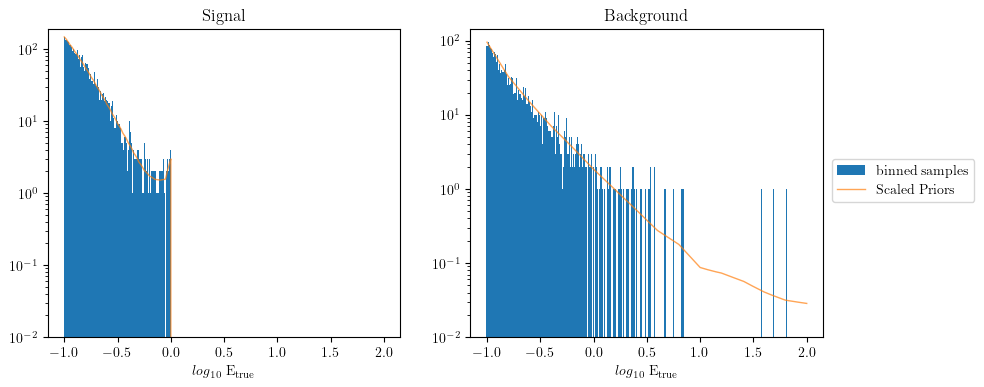

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Signal')

signal_plot_vals = np.sum(np.exp(DM_prior.logfunction(*np.meshgrid(log10_eaxis_true, longitude_axis_true, latitude_axis_true, indexing='ij'), 
                                                       logmass=log10_mass)+logjacob_true), axis=(1,2))
sig_true_histvals, sig_true_hist_bins, _ = plt.hist(siglogevals, bins=log10_eaxis_true-np.diff(log10_eaxis_true)[0]/2, label='binned samples')

plt.plot(log10_eaxis_true, signal_plot_vals/np.max(signal_plot_vals)*np.max(sig_true_histvals), lw=1, label="Scaled Prior", alpha=0.7)

plt.yscale('log')
plt.ylim([0.01,None])

plt.xlabel(r'$log_{10}$ E$_{\rm{true}}$')

plt.subplot(122)
plt.title('Background')


background_plot_vals = np.sum(np.exp(bkg_prior.logfunction(*np.meshgrid(log10_eaxis_true, longitude_axis_true, latitude_axis_true, indexing='ij'),)+logjacob_true), 
                              axis=(1,2))
background_true_histvals, background_true_hist_bins, _ = plt.hist(bkglogevals, bins=log10_eaxis_true-np.diff(log10_eaxis_true)[0]/2, label='binned samples')


plt.plot(log10_eaxis_true, background_plot_vals/np.max(background_plot_vals)*np.max(background_true_histvals), lw=1, label="Scaled Priors", alpha=0.7)

plt.yscale('log')
plt.ylim([0.01,None])
plt.legend(bbox_to_anchor=(1.45,0.6))
plt.xlabel(r'$log_{10}$ E$_{\rm{true}}$')
plt.show()


With a change in the overall normalisation for the prior functions, the histograms should roughly match the plotted priorvalues.

And then we'll just have a quick look at the sky position sampling.

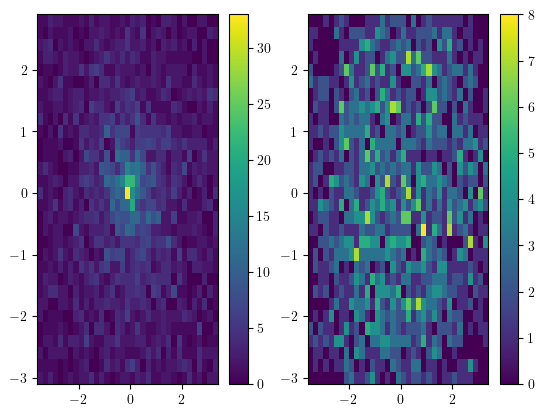

In [15]:
from matplotlib.colors import LogNorm


plt.figure()
plt.subplot(121)
plt.hist2d(siglonvals,siglatvals, 
           bins=(longitude_axis_true-np.diff(longitude_axis_true)[0]/2, latitude_axis_true-np.diff(latitude_axis_true)[0]/2))#, norm=LogNorm(vmin=1))
plt.colorbar()

plt.subplot(122)
plt.hist2d(bkglonvals,bkglatvals, 
           bins=(longitude_axis_true-np.diff(longitude_axis_true)[0]/2, latitude_axis_true-np.diff(latitude_axis_true)[0]/2))#, norm=LogNorm(vmin=1))
plt.colorbar()

plt.show()

## 3. Measured Value Sampling

Now that we have our "true values" we can create our "measured" or "reconstructed" values by sampling the likelihoods given the true values.

We first sample the energy dispersion to get the measured (log10) energy values. This should take less than 1 minute on a relatively modern laptop.

In [16]:
from tqdm.autonotebook import tqdm as notebook_tqdm

signal_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
bkg_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)]


 16%|█▋        | 489/3000 [00:00<00:02, 1217.31it/s]/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/documentation/../gammabayes/likelihood.py:90: RuntimeWarning: invalid value encountered in subtract
  loglikevalswithlogjacob = loglikevalswithlogjacob - logsumexp(loglikevalswithlogjacob, axis=(*np.arange(self.axes_dim),))
100%|██████████| 2000/2000 [00:01<00:00, 1305.00it/s]


We then sample the point spread function to get the measured sky position values. This will take a little longer but still under a minute.

In [17]:
sig_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
bkg_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)]


100%|██████████| 2000/2000 [00:14<00:00, 137.15it/s]


Now let's have a thorough look at our outputs.

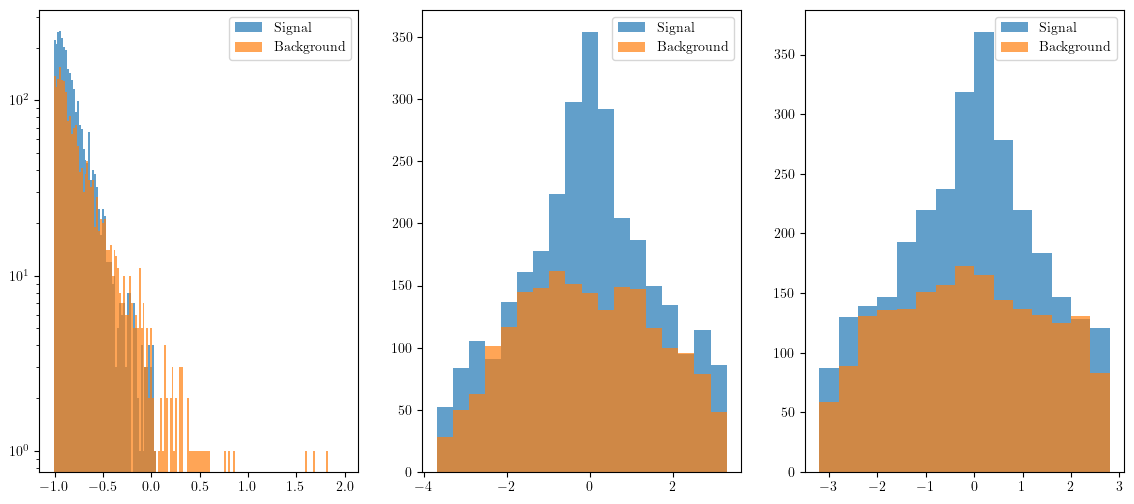

In [18]:
alpha=0.7
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.hist(signal_log10e_measured, bins=log10_eaxis-np.diff(log10_eaxis)[0]/2, color='tab:blue', alpha=alpha, label='Signal')
plt.hist(bkg_log10e_measured,   bins=log10_eaxis-np.diff(log10_eaxis)[0]/2, color='tab:orange', alpha=alpha, label='Background')
plt.yscale('log')
plt.legend()

plt.subplot(132)

plt.hist(np.asarray(sig_lonlat_psf_samples).T[0,:], bins=longitude_axis-spatial_resolution/2, color='tab:blue', alpha=alpha, label='Signal')
plt.hist(np.asarray(bkg_lonlat_psf_samples).T[0,:], bins=longitude_axis-spatial_resolution/2, color='tab:orange', alpha=alpha, label='Background')
plt.legend()


plt.subplot(133)

plt.hist(np.asarray(sig_lonlat_psf_samples).T[1,:], bins=latitude_axis-spatial_resolution/2, color='tab:blue', alpha=alpha, label='Signal')
plt.hist(np.asarray(bkg_lonlat_psf_samples).T[1,:], bins=latitude_axis-spatial_resolution/2, color='tab:orange', alpha=alpha, label='Background')
plt.legend()


plt.show()

The next recommended notebook to follow is called `hyperparameter_inference.ipynb` which analyses the simulations found here to reconstruct the $log_{10}$ mass value and fraction of events that come from the signal.